# Feasibility Analysis in MAGNUS

The module `NSFeas` in `MAGNUS` provides a set of methods to define and solve feasibility problems using nested sampling.  `NSFeas` leverages the DAG evaluation capability in `pyMC` to run the scenario simulations internally. Additionally, capability to embed ordinary differential equations (ODEs) into a DAG can be leveraged from `CRONOS` to enable dynamic feasibility analysis.

## Feasibility Analysis of a Pair of Algebraic Constraints

We consider the following example from [Kusumo _et al_ (2019)](https://doi.org/10.1021/acs.iecr.9b05006) with two design variables, ${\bf d}:=(d_1, d_2)^\intercal$ and a single output, $y$ given by:
$$\begin{align}
y = \theta d_1^2 + d_2
\end{align}$$
with the model parameter $\theta$. Our goal is to characterize the probabilistic feasible set inside the a priori domain $\mathcal{D}_0 \coloneqq [-1, 1]^2$ defined by the following pair of constraints:
$$\begin{equation}
0.20 \leq y \leq 0.75
\end{equation}$$
We want to characterize the nominal case corresponding to $\theta_{\rm nom}=1$:
$$\begin{align}
\mathcal{D}_{\rm nom} \coloneqq \{ {\bf d}\in \mathcal{D}_0: 0.20\leq d_1^2+d_2 \leq 0.75 \}
\end{align}$$
We also want to characterize the probabilistic case under a normality assumption for the model parameters, $\theta \sim \mathcal N(1,\sqrt{3})$:
$$\begin{align}
\mathcal{D}_\alpha \coloneqq  \left\{ {\bf d}\in \mathcal{D}_0: \mathbb{P}\left[0.20\leq \theta d_1^2+d_2 \leq 0.75 \:\middle|\: \theta \sim \mathcal N(1,\sqrt{3}) \right] \geq \alpha \right\}
\end{align}$$
with a feasibility probability $\alpha\geq 0.9$.

We start by importing both the `PyMC` and `MAGNUS` modules:

In [1]:
import pymc
from magnus import NSFeas

Next, we define the DAG of the growth model in `pyMC`:

In [2]:
# Create DAG
DAG = pymc.FFGraph()
DAG.options.MAXTHREAD = 1

d = DAG.add_vars( 2, "d" )
p = DAG.add_var( "p" )
#p.set( 1 );
y = p*d[0]**2 + d[1]
print( "y = ", y.str() )

y =  d1 + p * SQR( d0 )


We instantiate an environment `NSFeas` and set the relevant options:

In [3]:
# Instantiate nested sampler
NS = NSFeas()

NS.options.DISPLEVEL = 1
NS.options.FEASCRIT  = NS.options.VAR #CVAR
NS.options.FEASTHRES = 0.05
NS.options.NUMLIVE   = 1000
NS.options.NUMPROP   = 16
NS.options.MAXITER   = 0

NS.set_dag( DAG )
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.set_control( d, [ -1, -1 ], [ 1, 1 ] )

We start with the nominal scenario with $p=1$. After setup, we conduct a nested sampling using the method `sample`:

In [4]:
NS.set_parameter( [p], [1] );
NS.setup()
NS.sample()


** INITIALIZING LIVE POINTS (1000)      0.00 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     1.2266e+00   268        0     3.0000e-01
     25     4.7273e-01   383      341     2.8028e-01
     50     2.8298e-01   488      583     2.6704e-01
     75     1.7798e-01   593      785     2.5646e-01
    100     1.0737e-01   714      959     2.4769e-01
    125     5.8271e-02   828     1111     2.4027e-01
    150     1.6362e-02   934     1235     2.3439e-01
    167    -1.8921e-03  1004     1306     2.3108e-01


0

We can retrieve the live points, dead points, or discarded points for plotting from the respective fields `live_points`, `dead_points` and `discard_points`:

In [5]:
import numpy as np
np.set_printoptions( threshold=10 )

( points, feas, *other ) = NS.live_points
print( points, "\n", feas )

[[ 0.59049265  0.12583467]
 [-0.18780553  0.43914642]
 [ 0.06925035  0.47092462]
 ...
 [ 0.16362624  0.72089026]
 [ 0.00654741  0.20224277]
 [-0.6171875   0.3671875 ]] 
 [[-0.27451624]
 [-0.27441733]
 [-0.27427977]
 ...
 [-0.00233619]
 [-0.00228564]
 [-0.00189209]]


A plot of the nominal feasible domain is shown below:

In [6]:
import matplotlib.pyplot as plt

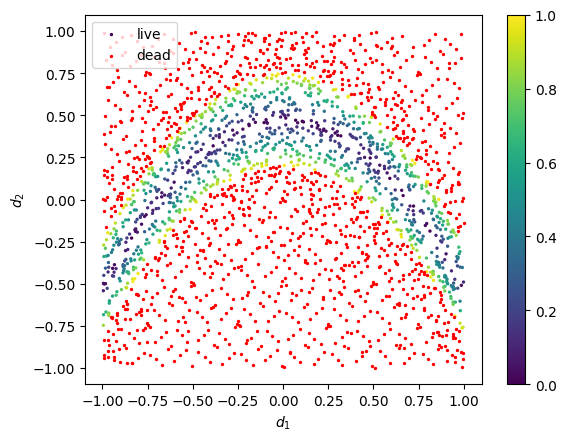

In [7]:
( livepoints, livefeas, *other ) = NS.live_points
( deadpoints, deadfeas, *other ) = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0], livepoints[:,1], c=livefeas[:,0], s=2, cmap='viridis', label='live')
plt.scatter(deadpoints[:,0], deadpoints[:,1], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Next, we consider the probabilistic scenario with 100 samples drawn from $p\sim\mathcal{N}(1,\sqrt{3})$:

In [8]:
np.random.seed( 0 )
psam = []
[ psam.append( [ np.random.normal( 1, np.sqrt(3) ) ] ) for i in range(0,100) ]

NS.set_parameter( [p], psam );
NS.setup()
NS.sample()


** INITIALIZING LIVE POINTS (1000)      0.01 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     4.2717e+00    53        0     3.0000e-01
     25     1.7696e+00    69      344     2.8011e-01
     50     1.2240e+00    96      599     2.6618e-01
     75     9.5163e-01   128      859     2.5269e-01
    100     7.4267e-01   165     1085     2.4153e-01
    125     5.9376e-01   201     1303     2.3122e-01
    150     4.4708e-01   251     1538     2.2061e-01
    175     3.3347e-01   327     1770     2.1060e-01
    200     2.4318e-01   418     2005     2.0094e-01
    225     1.7274e-01   513     2221     1.9244e-01
    250     1.0115e-01   644     2451     1.8379e-01
    275     4.9790e-02   800     2666     1.7605e-01
    300     1.6048e-03   992     2892     1.6827e-01
    302    -8.5218e-04  1003     2903     1.6790e-01


0

A plot of the probabilistic feasible domain with infeasibility threshold set to 10% is shown below:

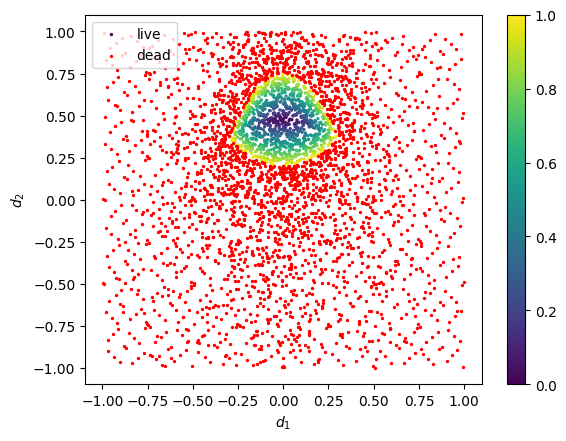

In [9]:
( livepoints, livefeas, *other ) = NS.live_points
( deadpoints, deadfeas, *other ) = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0], livepoints[:,1], c=livefeas[:,0], s=2, cmap='viridis', label='live')
plt.scatter(deadpoints[:,0], deadpoints[:,1], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Finally, we illustrate how to pass a custom model from python into the DAG to solve the same problem:

In [10]:
def model( x ):
  return [ x[2]*x[0]**2 + x[1] ]

OpY = pymc.FFCustom()
OpY.set_D_eval( model )
y = OpY( d+[p], 0 )
print( "y = ", y.str() )


y =  Custom[0][0]( d0, d1, p )


In [11]:
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.setup()
NS.sample()


** INITIALIZING LIVE POINTS (1000)      0.04 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     4.2717e+00    53        0     3.0000e-01
     25     1.7772e+00    71      339     2.8039e-01
     50     1.2484e+00    89      583     2.6704e-01
     75     9.6899e-01   126      828     2.5427e-01
    100     7.4416e-01   169     1067     2.4240e-01
    125     5.7835e-01   210     1311     2.3085e-01
    150     4.0456e-01   283     1564     2.1946e-01
    175     2.8656e-01   361     1808     2.0901e-01
    200     2.0909e-01   450     2021     2.0029e-01
    225     1.4205e-01   551     2247     1.9144e-01
    250     8.8049e-02   666     2453     1.8371e-01
    275     3.9366e-02   817     2668     1.7598e-01
    298    -1.3275e-03  1005     2870     1.6901e-01


0

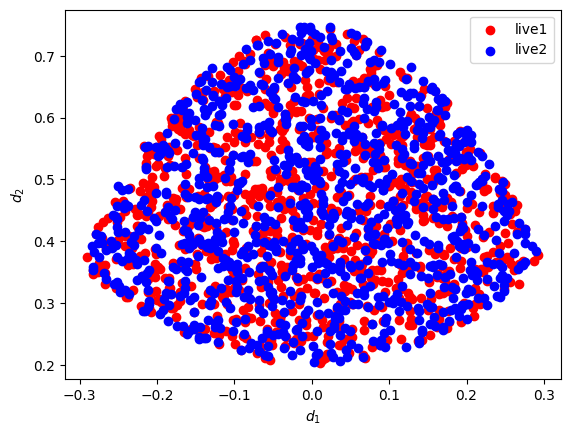

In [12]:
( livepoints2, livefeas2, *other ) = NS.live_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0],  livepoints[:,1],  c='r', label='live1')
plt.scatter(livepoints2[:,0], livepoints2[:,1], c='b', label='live2')
plt.legend(loc="best")
plt.show()